# Pipelines

A data science projects is an interative process that often leads to messy notebooks, and messy code.

It can feel a little chaotic, and during kaggle competitions and flatiron bakeoffs, the last thing many data scientists want to do is write the code from scratch that would compile their preprocessing and modeling steps into a single pipeline.

**That is where Sklearn Pipelines become useful.**

In this notebook, we will 
- Import data containing the policies written by the Bernie Sanders and Elizabeth Warren Presidential Campaigns. 
- Feature engineer numerical features
- Create a pipeline that scales numerical features and vectorizes test features
- Run the pipeline through a Gridsearch
- Run test data through our pipeline to develop predictions

In [1]:
# Base Libraries
import pandas as pd
import numpy as np
import pickle

# Data Processing
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, LabelBinarizer

# Machine Learning
from Transformers import TextSelector, NumberSelector
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, confusion_matrix, classification_report

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

In the cell below, three functions are written to
- Remove stopwords
- Calculate the average word length of a document
- Evaluation a classification model

In [2]:
stops = stopwords.words('english')
def remove_stopwords(text):
    '''removes stopwords for a string using a 
       previously loaded stops dataset'''
    split = word_tokenize(text)
    stopped = [word for word in split if word not in stops]
    joined = ' '.join(stopped)
    return joined

def average_word_length(text):
    '''counts the average word length for a given document'''
    split = word_tokenize(text)
    lengths = []
    for word in split:
        lengths.append(len(word))
    
    return np.mean(lengths)

def evaluation(y, y_hat, title = 'Confusion Matrix'):
    '''takes in predicted and true values.
    The function then prints out a classifcation report
    as well as a confusion matrix using seaborn's heatmap.'''
    cm = confusion_matrix(y, y_hat)
    precision = precision_score(y, y_hat, average = 'weighted')
    recall = recall_score(y, y_hat, average = 'weighted')
    accuracy = accuracy_score(y,y_hat)
    print(classification_report(y, y_hat))
    print('Accurancy: ', accuracy)
    sns.heatmap(cm,  cmap= 'Greens', annot=True)
    plt.xlabel('predicted')
    plt.ylabel('actual')
    plt.title(title)
    plt.show()

The features for our training data are saved in this repo with the path 


```'data/train_data.csv'```



And our target path:

```'data/train_labels.csv'```

In [3]:
# Import data
df = pd.read_csv('data/train_data.csv')
target = pd.read_csv('data/train_labels.csv')
print('---------------------------------------------------------------------')
print('                              Features')
print('---------------------------------------------------------------------')
print(df.head(3))
print('---------------------------------------------------------------------')
print('                               Target')
print('---------------------------------------------------------------------')
print(target.head(3))

---------------------------------------------------------------------
                              Features
---------------------------------------------------------------------
   Unnamed: 0  id                                          name  \
0          49  49  My Plan to Fight Global Financial Corruption   
1          33  33                                Foreign Policy   
2          16  16      Comprehensive Debt Relief to Puerto Rico   

                                              policy candidate  
0  When the Panama Papers were released in 2016, ...    warren  
1  From endless wars that strain military familie...    warren  
2  As published on Medium on May 2nd, 2019:\nI’ve...    warren  
---------------------------------------------------------------------
                               Target
---------------------------------------------------------------------
   Unnamed: 0  id  target
0           0  49       1
1           1  33       1
2           2  16       1


The id column is the join column for our training features and training labels. 

**Let's set that as the index for both dataframes.**

In [4]:
df.set_index('id', inplace = True)
df = df[['name', 'policy', 'candidate']]

target = target[['id', 'target']]
target.set_index('id', inplace = True)

Our features look like this:

| name                               | policy                      | candidate             |
|------------------------------------|-----------------------------|-----------------------|
| The published title for the policy | The full text of the policy | Name of the candidate |

Let's create a new feature that merges the name and policy of the column

In [5]:
# Combine Document Title and Document Body
df['combined'] = df.name + ' ' + df.policy

**Great**, now let's create a column called 'data' that will be the text data that we manipulate and run through out model.

In the cell below we will:

1. Create the 'data' column
2. Lower our text data
3. Remove punctuation
4. Remove Stop words
5. Remove words that contain digits
6. Measure the word count for each document
7. Measure the average word length for each document
8. Isolate our modeling data
9. Run a train test split of our modeling data

In [6]:
# Lower text
df['data'] = df.combined.apply(lambda x: x.lower())

# Remove punctuation
df.data = df.data.apply(lambda s: s.translate(str.maketrans('', '', string.punctuation)))

# Remove stopwords
df.data = df.data.apply(remove_stopwords)

# Remove words that contain digits
df.data = df.data.apply(lambda words: ' '.join(s for s in words.split() if not any(c.isdigit() for c in s)))

# Create feature the measures word count
df['length'] = df.data.apply(lambda x: len(word_tokenize(x)))

# Create feature that measures average word length of document
df['av_word_length'] = df.data.apply(average_word_length)


# Isolate modeling data
features = ['data', 'length', 'av_word_length']
X = df[features]
y = target.target

# Split data for modeling
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Create a Pipeline for Preprocessing

To create a pipeline what we can run test data through, we need to tell the pipeline what to do with each feature.

To do this, we will build our own Data Transformer using, Sklearn's **BaseEstimator** & **TransformerMixin**
>[Here is an article on BaseEstimator and TransformerMixin](https://towardsdatascience.com/custom-transformers-and-ml-data-pipelines-with-python-20ea2a7adb65)

These transformers will return specific columns to the pipeline so we can apply specific transformation. 

The custom transformers are saved in a separate .py file in this repo called Transformers.py and imported into the notebook in the first cell. This is done so that our model can be pickled at the end of our project.

**For easy reference here a screenshot of the Transformers.py file**

![](images/transformer_code.png)

Now all we have to do is create pipelines for each of our columns.

To create a pipeline, we instantiate a Sklearn Pipeline object 'Pipeline( )' and inside that object we add a list of tuples. 

Each tuple is a step in our pipeline and each tuple contains two items:
1. A string decribing what is happening in that pipeline step
2. The object that runs the code for that step

In [7]:
text = Pipeline([
                ('selector', TextSelector(key='data')),
                ('tfidf', TfidfVectorizer(stop_words='english'))
            ])

length =  Pipeline([
                ('selector', NumberSelector(key='length')),
                ('standard', StandardScaler())
            ])

word_length = Pipeline([
                    ('selector', NumberSelector(key='av_word_length')),
                     ('standard', StandardScaler())
])

Now that we have created individual pipelines for our columns, we combine them using Sklearn's **FeatureUnion**

In [8]:
feats = FeatureUnion([('text', text), 
                      ('length', length),
                      ('word_length', word_length)])

FeatureUnion is not a pipeline, it merely joins the data from each pipeline. 

To make out Pipeline actionable, we have to create one last pipeline containing our FeatureUnion.

In [9]:
feature_processing = Pipeline([('feats', feats)])

Now, we can run all of our data transformations at once. 

Because we used the TfidfVectorizer, this results in a sparse matrix.

In [10]:
feature_processing.fit_transform(X_train)

<60x9121 sparse matrix of type '<class 'numpy.float64'>'
	with 37203 stored elements in Compressed Sparse Row format>

Adding a machine learning model to our pipeline is as simple as adding another tuple to our pipeline

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.62      1.00      0.76        13

    accuracy                           0.62        21
   macro avg       0.31      0.50      0.38        21
weighted avg       0.38      0.62      0.47        21

Accurancy:  0.6190476190476191


/Users/joel/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/joel/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


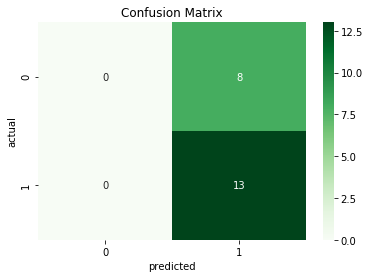

In [11]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

pipeline.fit(X_train, y_train)

preds = pipeline.predict(X_test)
evaluation(y_test, preds)

# Grid Search

Creating a pipeline is great, but what if we want to tune our model?

What if we want to tune multiple steps in our pipeline?

Pipeline objects have a simple way of returning all the parameters that can be tuned.

In [12]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'features', 'classifier', 'features__n_jobs', 'features__transformer_list', 'features__transformer_weights', 'features__verbose', 'features__text', 'features__length', 'features__word_length', 'features__text__memory', 'features__text__steps', 'features__text__verbose', 'features__text__selector', 'features__text__tfidf', 'features__text__selector__key', 'features__text__tfidf__analyzer', 'features__text__tfidf__binary', 'features__text__tfidf__decode_error', 'features__text__tfidf__dtype', 'features__text__tfidf__encoding', 'features__text__tfidf__input', 'features__text__tfidf__lowercase', 'features__text__tfidf__max_df', 'features__text__tfidf__max_features', 'features__text__tfidf__min_df', 'features__text__tfidf__ngram_range', 'features__text__tfidf__norm', 'features__text__tfidf__preprocessor', 'features__text__tfidf__smooth_idf', 'features__text__tfidf__stop_words', 'features__text__tfidf__strip_accents', 'features__text__tfidf__sublinear

Notice that the name of these parameters are tied to the descriptions we gave to the steps in our Pipeline.

```'features__text__tfidf__analyzer'``` for example was apart of our ```features``` step. The features step contained the step ```text``` which contained the step ```tfidf```.

If you were to look at the documentation for TfidfVectorizer, there is a paremeter called ```analyzer```. GridSearch uses the descriptions we give to each step of our Pipeline to itentify which parameter to tune. For this reason it helpful to use unique descriptions for each step you may be interested in tuning.


Let's tune a few parameters

In [13]:
hyperparameters = { 'features__text__tfidf__max_df': [0.9, 0.95],
                    'features__text__tfidf__ngram_range': [(1,1), (1,2)],
                   'classifier__max_depth': [50, 70],
                    'classifier__min_samples_leaf': [1,2]
                  }
clf = GridSearchCV(pipeline, hyperparameters, cv=5)
 

clf.fit(X, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('features',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('text',
                                                                        Pipeline(memory=None,
                                                                                 steps=[('selector',
                                                                                         TextSelector(key='data')),
                                                                                        ('tfidf',
                                                                                         TfidfVectorizer(analyzer='word',
                                                                                                         binary=False,
                                                                       

Let's print out the parameter settings that returned the best score.

In [14]:
clf.best_params_

{'classifier__max_depth': 50,
 'classifier__min_samples_leaf': 1,
 'features__text__tfidf__max_df': 0.9,
 'features__text__tfidf__ngram_range': (1, 1)}

A handy tool is .refit, that immediately retrains our model on the features that have been identified by out GridSearch

In [15]:
clf.refit

True

Now, we can make predictions just like we would with any other model.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      1.00      1.00        57

    accuracy                           1.00        81
   macro avg       1.00      1.00      1.00        81
weighted avg       1.00      1.00      1.00        81

Accurancy:  1.0


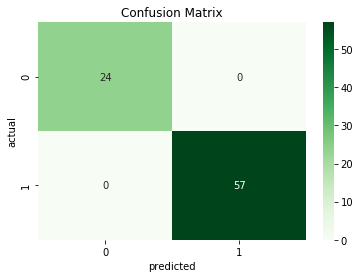

In [16]:
preds = clf.predict(X)
probs = clf.predict_proba(X)

evaluation(y, preds)

What is incredible is that we can now save our model as a single object.

This object contains all the steps of our pipeline.

When we use ```.predict``` the model funnels the data through each step of the pipeline before returning predictions.

In [17]:
filename = 'finalized_model.sav'
with open(filename, 'wb') as f:
    pickle.dump(clf, f)

# Putting it all together

Let's put all of our code together, so that we can 
1. import our test data
2. quickly format the data
3. Clean our text data
3. Repoduce our feature engineering
4. Use our Pipeline to produce predictions

In [18]:
def remove_stopwords(text):
    split = word_tokenize(text)
    stopped = [word for word in split if word not in stops]
    joined = ' '.join(stopped)
    return joined

def average_word_length(text):
    split = word_tokenize(text)
    lengths = []
    for word in split:
        lengths.append(len(word))
    
    return np.mean(lengths)

def processing(df):

    df['combined'] = df.name + ' ' + df.policy

    #lower text data
    df['data'] = df.combined.apply(lambda x: x.lower())

    #remove punctuation
    df.data = df.data.apply(lambda s: s.translate(str.maketrans('', '', string.punctuation)))
    
    #remove stopwords
    df.data = df.data.apply(remove_stopwords)
    stops = stopwords.words('english')
    
    #Remove words that contain digits
    df.data = df.data.apply(lambda words: \
                            ' '.join(s for s in words.split() if not any(c.isdigit() for c in s)))
    
    #Length of document
    df['length'] = df.data.apply(lambda x: len(word_tokenize(x)))
    
    #Average Word Length
    df['av_word_length'] = df.data.apply(average_word_length)
    
    features = ['data', 'length', 'av_word_length']
    X = df[features]
    
    return X

def predict(data_path, model_path = 'finalized_model.sav'):
    
    data = pd.read_csv(data_path)
    data.set_index('id', inplace = True)
    data = data[['name', 'policy', 'candidate']]
    
    # Preprocessing
    data = processing(data)
    
    # Import Pipeline

    with open(model_path, 'rb') as file:
        model = pickle.load(file)
    
    # Predictions
    preds = model.predict(data)
    
    return preds

In [19]:
pred = predict('data/test_data.csv')

Now let's import the labels for our test data and see how we did.

In [20]:
y_true = pd.read_csv('data/test_labels.csv')
y_true = y_true[['id', 'target']]
y_true.set_index('id', inplace = True)

              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.86      1.00      0.92        18

    accuracy                           0.89        28
   macro avg       0.93      0.85      0.87        28
weighted avg       0.91      0.89      0.89        28

Accurancy:  0.8928571428571429


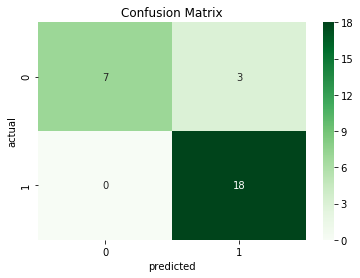

In [21]:
evaluation(y_true, pred)